In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

C:\ProgramData\Anaconda3\envs\ml-zoomcamp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-16 16:10:06--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3%  901K 1s
    50K .......... .......... .......... .......... ..........  7% 3.46M 1s
   100K .......... .......... .......... .......... .......... 10% 1.46M 1s
   150K .......... .......... .......... .......... .......... 14% 4.85M 1s
   200K .......... .......... .......... .......... .......... 17% 1.57M 1s
   250K .......... .......... .......... .......... .......... 21% 4.36M 1s
   300K .......... .......... .......... .......... .......... 25% 5.20M 0s
   350K .......... .......... ..

## Loading the data

Use only the following columns:
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.


In [2]:
df = pd.read_csv('./housing.csv')

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
features = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'
]

In [4]:
df.isnull().sum(axis = 0)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(0)

In [6]:
median_house_val_orig = df['median_house_value']

df['median_house_value'] = np.log1p(df['median_house_value'].values)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [7]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [8]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [9]:
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [10]:
df_train.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND


In [11]:
dv = DictVectorizer(sparse = False)

train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

In [12]:
feature_names_out = dv.get_feature_names_out()
feature_names_out

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'ocean_proximity=ISLAND',
       'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN',
       'population', 'total_bedrooms', 'total_rooms'], dtype=object)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 
* Train a model with `max_depth=1`.

Which feature is used for splitting the data? **ocean_proximity=INLAND**
* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`


In [13]:
dtreg = DecisionTreeRegressor(max_depth = 1, random_state = 1)

dtreg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [14]:
print(export_text(dtreg, feature_names = dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\ProgramData\Anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

Train a random forest model with these parameters:
* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

What's the RMSE of this model on validation? **0.2457**
- 0.05
- 0.25
- 0.55
- 0.85


In [15]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [17]:
y_pred = rf.predict(X_val)

print(rmse(y_val, y_pred))

0.2457383433183843


In [18]:
print(mean_squared_error(y_val, y_pred, squared=False))

0.2457383433183843


## Question 3

Now let's experiment with the `n_estimators` parameter
* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? **150**
- 10
- 50
- 70
- 150


In [19]:
n_estimators = np.linspace(10, 200, 20, dtype = int)

n_estimators

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [20]:
scores = []

for n in n_estimators:
    
    rf_3 = RandomForestRegressor(n_estimators = n, random_state = 1)
    rf_3.fit(X_train, y_train)
    
    y_pred = rf_3.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared = False)
    print('n: ', n, ', RMSE: ', score)
    
    scores.append(score)

n:  10 , RMSE:  0.2457383433183843
n:  20 , RMSE:  0.23926159143162362
n:  30 , RMSE:  0.23571658024242995
n:  40 , RMSE:  0.2345829928852663
n:  50 , RMSE:  0.23310354554874652
n:  60 , RMSE:  0.2328429808263216
n:  70 , RMSE:  0.23238404627057696
n:  80 , RMSE:  0.2325270885881096
n:  90 , RMSE:  0.2322152441944244
n:  100 , RMSE:  0.2319683398110155
n:  110 , RMSE:  0.2315183513876384
n:  120 , RMSE:  0.23162059722289452
n:  130 , RMSE:  0.23170961618874023
n:  140 , RMSE:  0.23169246809784283
n:  150 , RMSE:  0.23169445775520764
n:  160 , RMSE:  0.23169721161526824
n:  170 , RMSE:  0.23162910205851622
n:  180 , RMSE:  0.2317902360719715
n:  190 , RMSE:  0.2317624141810945
n:  200 , RMSE:  0.23165006514034595


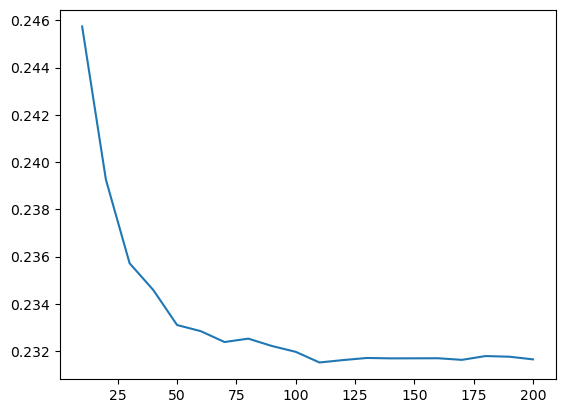

In [21]:
plt.plot(n_estimators, scores)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`: **25**
* 10
* 15
* 20
* 25


In [22]:
scores_depth_n = []

max_depth = [10, 15, 20, 25]

for d in max_depth:
    for n in n_estimators:
        
        rf_4 = RandomForestRegressor(n_estimators = n, max_depth = d, random_state = 1)
        rf_4.fit(X_train, y_train)
        
        y_pred = rf_4.predict(X_val)
        
        score = mean_squared_error(y_val, y_pred, squared = False)
        
        #print('d: ', d, ', n: ', n, ', RMSE: ', score)
        scores_depth_n.append((d, n, score))
        

cols = ['depth', 'n_est', 'rmse']
df_scores_depth_n = pd.DataFrame(scores_depth_n, columns = cols)

In [23]:
df_scores_depth_n.sort_values(by = ['rmse']).head()

,depth,n_est,rmse
70,25,110,0.231255
71,25,120,0.231297
76,25,170,0.231440
73,25,140,0.231458
75,25,160,0.231484


In [24]:
df_scores_pivot = df_scores_depth_n.pivot(index = 'n_est', columns = 'depth', values = 'rmse')
df_scores_pivot.head()

depth,10,15,20,25
n_est,,,,
10,0.255042,0.244790,0.246327,0.246069
20,0.252784,0.239306,0.238937,0.238804
30,0.251647,0.236909,0.235886,0.235454
40,0.251062,0.235983,0.234844,0.234338
50,0.250192,0.234730,0.233411,0.232747


<AxesSubplot:xlabel='depth', ylabel='n_est'>

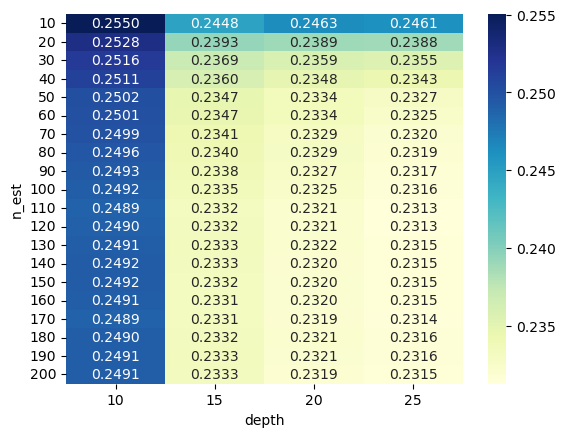

In [25]:
sns.heatmap(df_scores_pivot, annot = True, fmt = ".4f", cmap = "YlGnBu")

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

What's the most important feature? **median_income**
* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`


In [26]:
rf_5 = RandomForestRegressor(n_estimators = 10, max_depth = 20, random_state = 1, n_jobs=-1)
rf_5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [27]:
importances = rf_5.feature_importances_

f_importances = dict(zip(feature_names_out, importances))
dict(sorted(f_importances.items(), key = lambda item: item[1]))

{'ocean_proximity=ISLAND': 0.000356806262947593,
 'ocean_proximity=NEAR BAY': 0.00044866197239988755,
 'ocean_proximity=<1H OCEAN': 0.003007237495106814,
 'ocean_proximity=NEAR OCEAN': 0.004227624463177561,
 'households': 0.01695731830740333,
 'total_bedrooms': 0.019041256180901026,
 'total_rooms': 0.020536468711052403,
 'population': 0.030918019662506523,
 'housing_median_age': 0.03309389968532549,
 'longitude': 0.09626498762322835,
 'latitude': 0.10133397120516323,
 'ocean_proximity=INLAND': 0.31090084170805665,
 'median_income': 0.3629129067227312}

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:
* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset? **0.3**
* 0.3
* 0.1
* Both gives same


In [28]:
features = dv.get_feature_names()
features = [i.replace("=<", "_").replace("=","_") for i in features]
features

C:\ProgramData\Anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [29]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [30]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,}

In [31]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [32]:
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round = 100, evals = watchlist)

[0]	train-rmse:8.12733	val-rmse:8.13245
[1]	train-rmse:5.69586	val-rmse:5.70070
[2]	train-rmse:3.99539	val-rmse:4.00041
[3]	train-rmse:2.80712	val-rmse:2.81079
[4]	train-rmse:1.97833	val-rmse:1.98175
[5]	train-rmse:1.40218	val-rmse:1.40741
[6]	train-rmse:1.00099	val-rmse:1.00700
[7]	train-rmse:0.72751	val-rmse:0.73439
[8]	train-rmse:0.54190	val-rmse:0.55047
[9]	train-rmse:0.42167	val-rmse:0.43234
[10]	train-rmse:0.34481	val-rmse:0.35782
[11]	train-rmse:0.29835	val-rmse:0.31360
[12]	train-rmse:0.27095	val-rmse:0.28864
[13]	train-rmse:0.25268	val-rmse:0.27335
[14]	train-rmse:0.24295	val-rmse:0.26605
[15]	train-rmse:0.23555	val-rmse:0.26044
[16]	train-rmse:0.22630	val-rmse:0.25229
[17]	train-rmse:0.22232	val-rmse:0.24902
[18]	train-rmse:0.22029	val-rmse:0.24826
[19]	train-rmse:0.21791	val-rmse:0.24696
[20]	train-rmse:0.21580	val-rmse:0.24624
[21]	train-rmse:0.21160	val-rmse:0.24334
[22]	train-rmse:0.20975	val-rmse:0.24245
[23]	train-rmse:0.20904	val-rmse:0.24269
[24]	train-rmse:0.20703	va

In [33]:
y_pred = xgb_model.predict(dval)

print(mean_squared_error(y_val, y_pred, squared = False))

0.2260957847928297


In [34]:
xgb_params_2 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,}

In [35]:
xgb_model_2 = xgb.train(xgb_params_2, dtrain, num_boost_round = 100, evals = watchlist)

[0]	train-rmse:10.44371	val-rmse:10.44938
[1]	train-rmse:9.40118	val-rmse:9.40684
[2]	train-rmse:8.46290	val-rmse:8.46831
[3]	train-rmse:7.61859	val-rmse:7.62391
[4]	train-rmse:6.85878	val-rmse:6.86368
[5]	train-rmse:6.17513	val-rmse:6.17987
[6]	train-rmse:5.55994	val-rmse:5.56437
[7]	train-rmse:5.00643	val-rmse:5.01061
[8]	train-rmse:4.50845	val-rmse:4.51264
[9]	train-rmse:4.06043	val-rmse:4.06461
[10]	train-rmse:3.65741	val-rmse:3.66135
[11]	train-rmse:3.29492	val-rmse:3.29877
[12]	train-rmse:2.96894	val-rmse:2.97284
[13]	train-rmse:2.67573	val-rmse:2.67979
[14]	train-rmse:2.41195	val-rmse:2.41587
[15]	train-rmse:2.17500	val-rmse:2.17928
[16]	train-rmse:1.96213	val-rmse:1.96662
[17]	train-rmse:1.77065	val-rmse:1.77536
[18]	train-rmse:1.59880	val-rmse:1.60396
[19]	train-rmse:1.44376	val-rmse:1.44910
[20]	train-rmse:1.30499	val-rmse:1.31054
[21]	train-rmse:1.18080	val-rmse:1.18646
[22]	train-rmse:1.06879	val-rmse:1.07469
[23]	train-rmse:0.96912	val-rmse:0.97546
[24]	train-rmse:0.87914	

In [36]:
y_pred = xgb_model_2.predict(dval)

print(mean_squared_error(y_val, y_pred, squared = False))

0.2305416021993131
